<a href="https://colab.research.google.com/github/nguyenvietkhoa1409/Natural-Language-Processing-with-Transformer-textbook/blob/main/%5BNLP_with_Transformers%5D_Chapter_2_in_conclusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Implement Transformer Architecture </h1>

<h2>1. Create an example for testing</h2>

In [ ]:
from torch import nn
from torch.nn import functional as F
import torch

from transformers import AutoConfig, AutoTokenizer

In [ ]:
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

text = 'time flies like an arrow'
config = AutoConfig.from_pretrained(model_ckpt)
inputs = tokenizer(text, return_tensors='pt', add_special_tokens = False) #last arguement delete [CLS] and [SEP] token

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
inputs.keys()
inputs.input_ids

tensor([[ 2051, 10029,  2066,  2019,  8612]])

here we have the input_ids corresponding to the Tokenizer vocabulary id. Next, we convert each ids into embedding vector.

In [ ]:
#Retrieve the whole vocabulary embeddings with (vocab_size, embedd_size)
token_emb = nn.Embedding(config.vocab_size, config.hidden_size)

#transfrom input.input_ids to embedding vectors
input_embeds = token_emb(inputs.input_ids)
input_embeds.size()


torch.Size([1, 5, 768])

<h2>2. Scaled dot-product attention </h2>

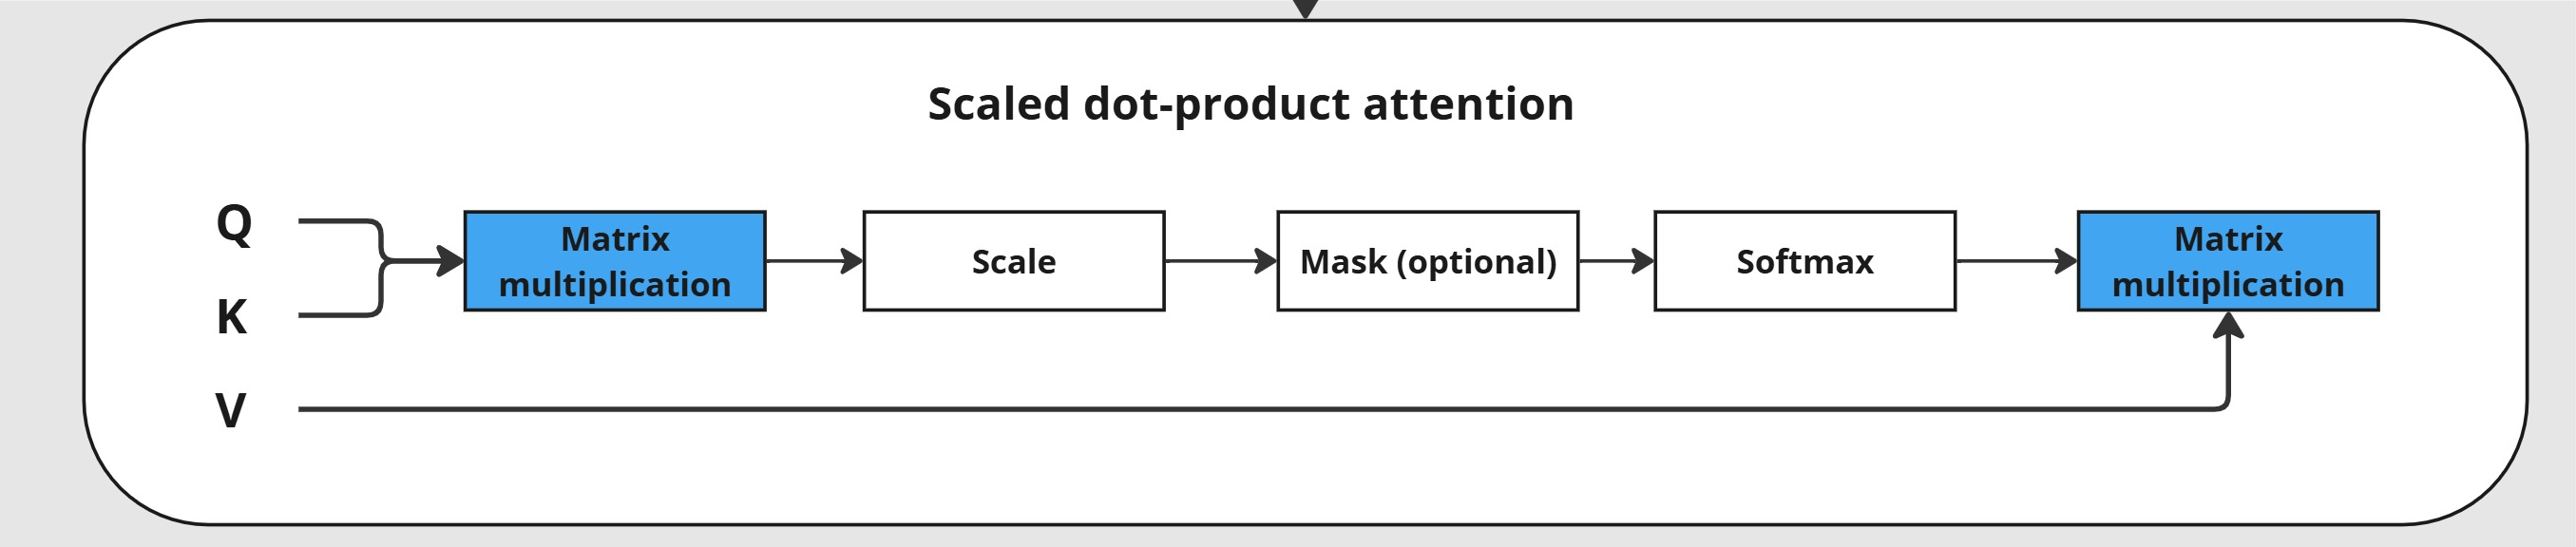

In [ ]:
from math import sqrt

def scaled_dot_product_attention(query, key, value):
  #Input: vector of (batch_size, num_tok, embed_size)
  #Compute attention scores of (num_tok x num_tok).
  dim_k = query.size(-1)
  #attention score matrix
  scores = torch.bmm(query, key.transpose(1,2))/sqrt(dim_k)
  #obtain weights to reduce the computational effort
  weights = F.softmax(scores, dim = -1)
  #update the value
  return torch.bmm(weights, value)



**Input**<br>
The function takes three input tensors:
- **`query`**: Tensor of shape `(batch_size, seq_len_q, dim_k)`, representing the queries used to compute attention.
- **`key`**: Tensor of shape `(batch_size, seq_len_k, dim_k)`, representing the keys that are compared against the queries.
- **`value`**: Tensor of shape `(batch_size, seq_len_k, dim_v)`, containing the actual values that contribute to the final output.

Each tensor is typically a 3D tensor, where:
- `batch_size`: The number of sequences processed at once.
- `seq_len_q`: The length of the query sequence.
- `seq_len_k`: The length of the key sequence.
- `dim_k`: The feature dimension of `query` and `key`.
- `dim_v`: The feature dimension of `value`.

##3. Multi-head attention

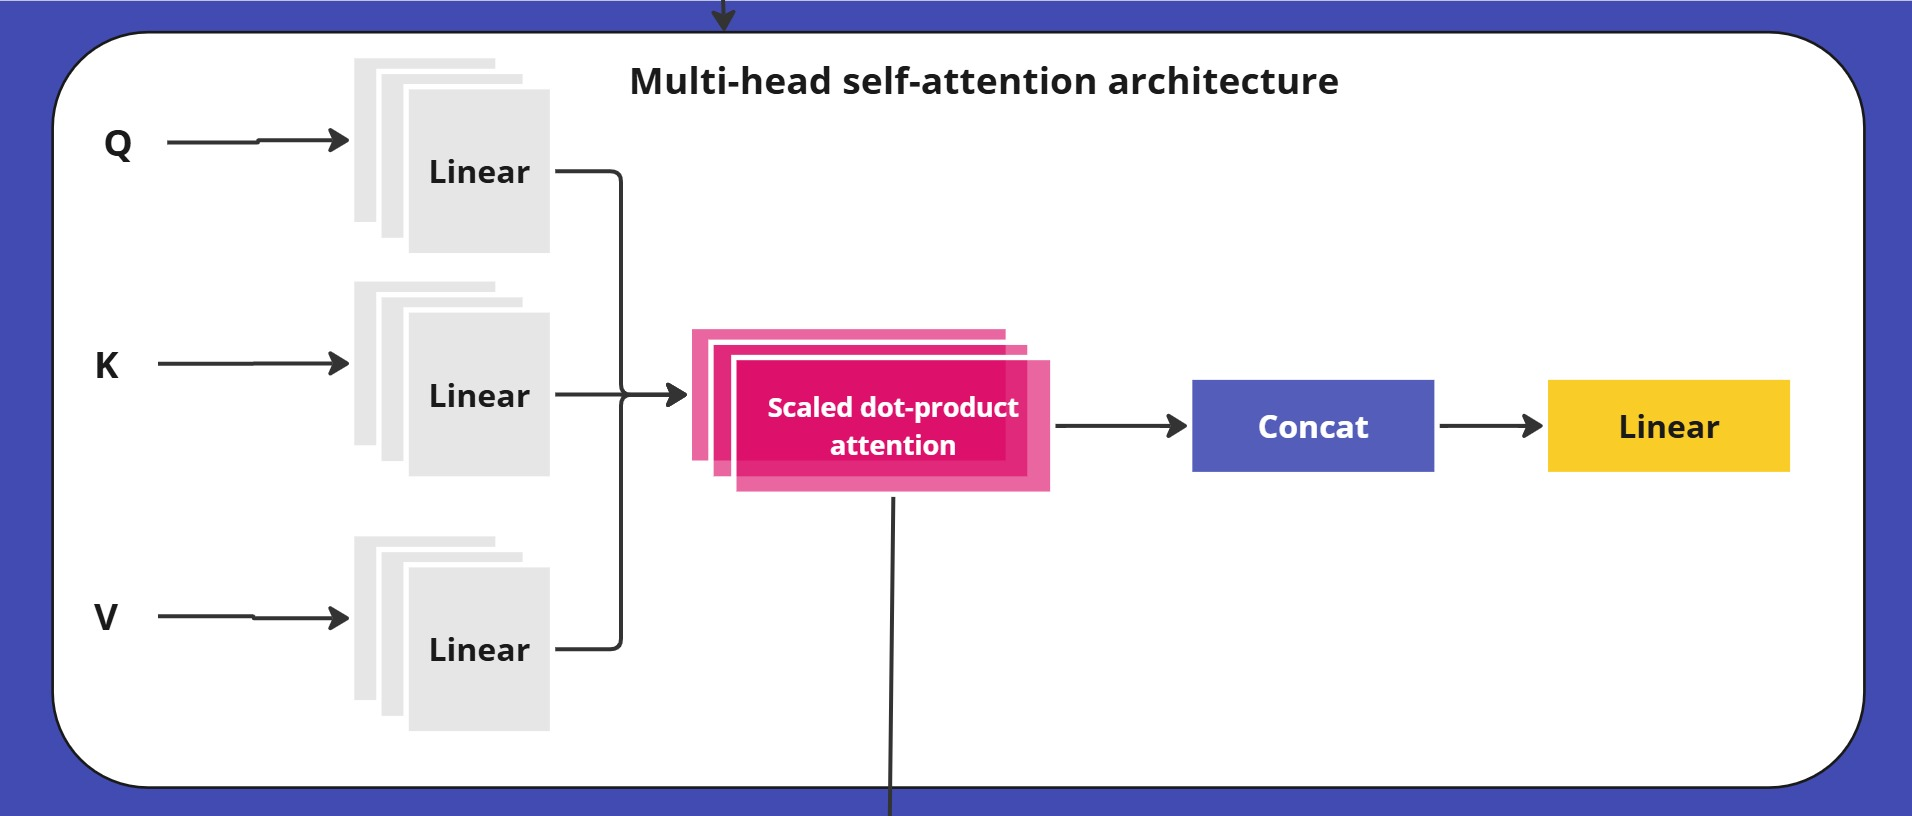

###3.1 Coding up an attention head

In [ ]:
class Attentionhead(nn.Module):
  def __init__(self, embed_dim, head_dim):
    super().__init__()
    #Project each embedding into query, key and value vectors.
    self.q = nn.Linear(embed_dim, head_dim)
    self.k = nn.Linear(embed_dim, head_dim)
    self.v = nn.Linear(embed_dim, head_dim)

  def forward(self, x):
    return scaled_dot_product_attention(self.q(x), self.k(x), self.v(x))

###3.2 Coding up multi-head attention layer

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, config):
    super().__init__()
    embed_dim = config.hidden_size
    head_dim = embed_dim //config.num_attention_heads
    num_head = config.num_attention_heads
    self.heads = nn.ModuleList(
        [Attentionhead(embed_dim, head_dim) for _ in range(num_head)]
    )
    self.output_linear = nn.Linear(embed_dim, embed_dim)
  def forward(self, x):
    x = torch.cat([head(x) for head in self.heads], dim = -1)
    x = self.output_linear(x)
    return x

The `self.output_linear` output here is Merging and Reweighting Attention Heads

1. Each head captures different relationships (e.g., syntax, entity recognition, long-range dependencies).
The linear layer learns the best way to combine these features instead of just stacking them side by side.
Ensuring Inter-Head Information Flow

2. Without this layer, each attention head would remain independent.
The linear transformation allows cross-head interactions, enabling deeper feature extraction.
Providing an Additional Learnable Transformation

3. The linear layer contains weights and biases, which help refine the attended representation.
This increases the expressiveness of the model before passing it to the next sublayer.
Facilitating Residual Connections

4. The Transformer architecture has skip connections that add the input back to the multi-head attention output.
Since the input and output both have hidden_dim, applying a learned transformation ensures smooth residual learning.

In [ ]:
multihead_attention = MultiHeadAttention(config)
multihead_attention(input_embeds).size()

torch.Size([1, 5, 768])

#### Define a function to track the learnable parameters

In [ ]:
def print_model_parameters(model):
    print("\nModel Parameter Breakdown:")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name}: {param.numel()} parameters")
    print(f"Total Parameters: {count_parameters(model)}")

# Example usage:
# multihead_attention = MultiHeadAttention(config)
# print_model_parameters(multihead_attention)


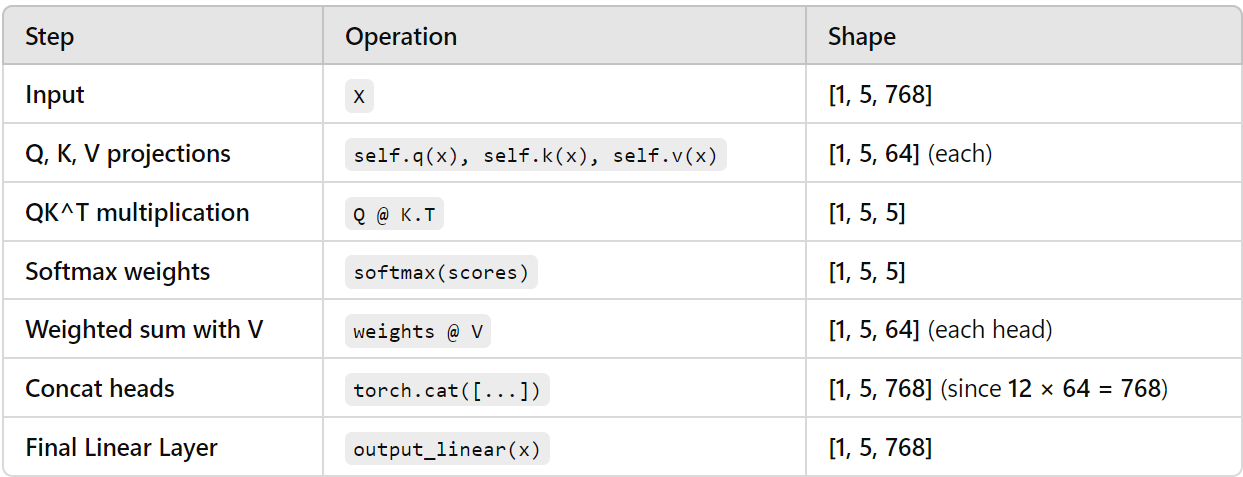

##4. Feed-forward layer

The feed-forward sublayer in the encoder and decoder is just a simple two-layer fully
connected neural network, but with a twist: instead of processing the whole sequence
of embeddings as a single vector, it processes each embedding **independently**. For this
reason, this layer is often referred to as a **position-wise feed-forward layer**.<br>
A rule of thumb from the literature is for the hidden size of
the first layer to be **four times** the size of the embeddings, and a GELU activation
function is most commonly used.

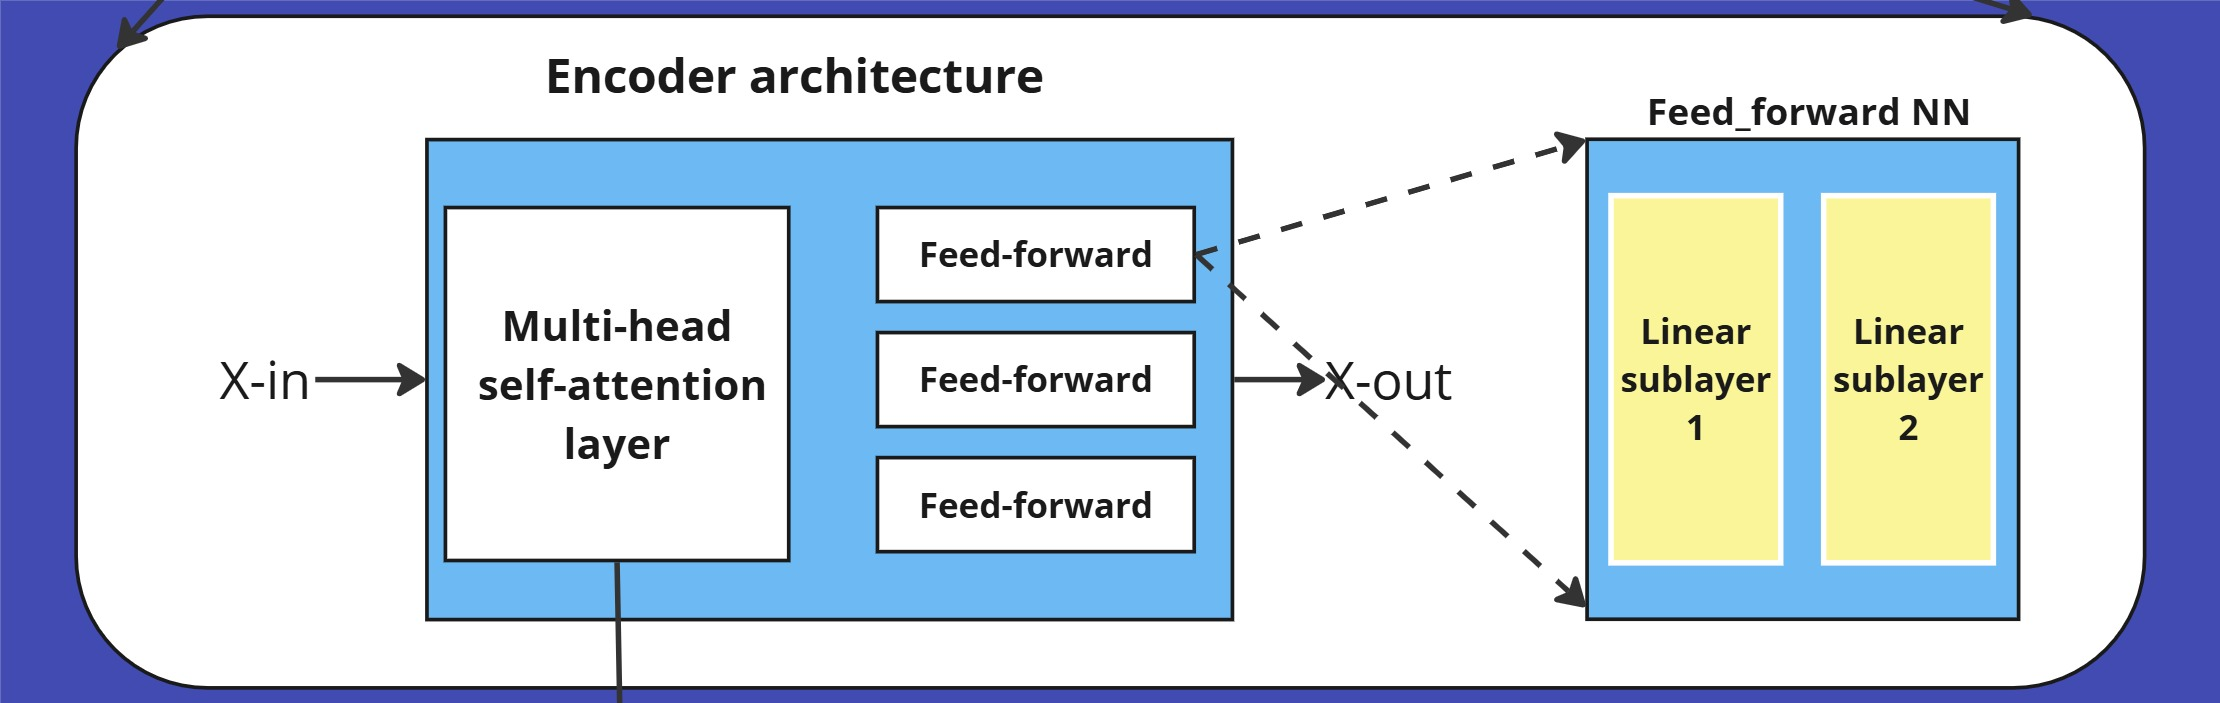

In [ ]:
#The rule of thumb is that
config.intermediate_size

3072

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, config):
    super().__init__()
    intermediate_size = config.intermediate_size
    self.dense_1 = nn.Linear(config.hidden_size, intermediate_size)
    self.dense_2 = nn.Linear(intermediate_size, config.hidden_size)
    self.gelu = nn.GELU()
    self.dropout =  nn.Dropout(config.hidden_dropout_prob)

  def forward(self, x):
    x = self.dense_1(x)
    x = self.gelu(x)
    x = self.dense_2(x)
    x = self.dropout(x)
    return x

**Explanation of why this layer processs each embedding independently**:
1. The weight matrix of linear_1 has the shape (768, 3072).
This means that for each token embedding (which is a 768-dimensional vector), the transformation is applied independently to convert it into a 3072-dimensional vector.
2. Each token gets transformed in the same way, but there's no interaction between different tokens.
**Example in case of mix-processing each embedding**:
1. define a mixing dense layer: `self.mixing_dense = nn.Linear(seq_len * hidden_dim, output_dim)`
2. flatten the input shape of (1, 5, 768) into (1, 5*678).
3. Apply linear transformation. Then the output is a linear combination of **all the embeddings**, not independent one.

###Conclude the whole process in Laymen's term

- Self-attention: Like a group discussion where every token "talks" to others.
- Feed-forward layer: Like individual study time where each token processes information separately.

##Adding layer Normalizatiotn

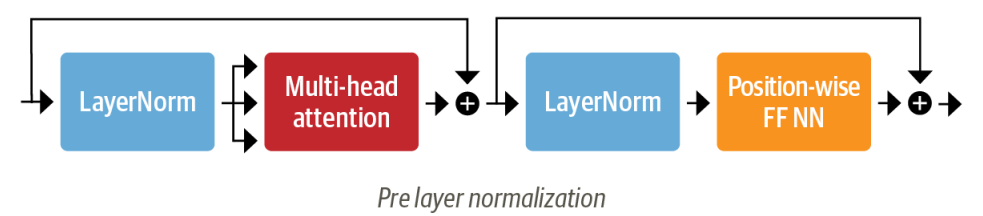

In [ ]:
class TransformersEncoderLayer(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.layer_norm_1 = nn.LayerNorm(config.hidden_size)
    self.layer_norm_2 = nn.LayerNorm(config.hidden_size)
    self.multihead_attn = MultiHeadAttention(config)
    self.feed_forward = FeedForward(config)
  def forward(self, x):
    hidden_state = self.layer_norm_1(x)
    x = x + self.multihead_attn(hidden_state)
    x = x + self.feed_forward(self.layer_norm_2(x))
    return x

In [ ]:
trans_encoder = TransformersEncoderLayer(config)
input_embeds.shape, trans_encoder(input_embeds).size()

(torch.Size([1, 5, 768]), torch.Size([1, 5, 768]))